# Shuttle through 10 µm QuBus

Now that the expeimental evidance of long-range shuttling approaches our ultimate goal, it is time to polish previous work.

## Task 1: Simplify the piece-weised pulse
> ### Issue:
> the measurement window of each piece-weised level yields large amount of dataset due to the high sample rate of AWG (i.e. 192/12.5 MHz = 15.36 µs). It is overkilled for loading or reading a single electron tunneling as it is rather slow i.e. in ms range, which as a result generates thousands data points for a tunnel event.

> ### Solutions: 
> From my experience, a time resolution of hundreds µs is sufficient to resolve a single blip due to tunneling. 
> 1. Making simple loading/reading pulse by `TablePT` or `ConstantPT` and let alazar card downsample data as intended.
>> #### Pridictable problems:
>> 1. pulse issue: ConstantPT has inconsistent usage of `Set` and `frozenset` --> Issue: 712. -- DONE
>> 2. atsaverage issue: how should I downsample data with given resolution? How to define mask properly?  
>> A: There was for long time a missunderstanding of mask definition. It is not directly related to the measurement resolution but just a part of information that `qupulse` will pass to `atsAverage` containing only the beginning time and the duration as a list of tuples. Then `atsAverage` will do the `operation` for each mask on demand. Therefore, it is not necessary to define the time resolution of measurements in `qupulse` by explicitly defining a measurement window for each small piece of pulse. It will only couple the resolution of pulse with that of data acquisation and one doesn't gain anything from that.
>> 3. MATLAB issue: the matlab interface will be buggy for sure. Maybe `conf_seq` has already implemented similar functionalities?  
>> A: It should be an issue since `Chunked Average` provided by `AtsAverage` works very well with my matlab scripts thanks for Simon's implemantation.  
> 2. Making more ineligent pulse as a physist? Just wrapping piece-weised pulses by one more `RepetitionPT` where `measurement_window` can be defined by a given parameter?
>> Other than an un-readable pulse that may potentially make analysis difficult, I don't see any problems by now...  
>> A: I did write the pulse in such a way and it works but just stupid.  

> Others?

---

Anyway, try to avoid using `PointPT` first.


In [2]:
import sympy
from qupulse.pulses import ConstantPT, RepetitionPT

n_segment, sample_rate, t_res, t_hold = sympy.sympify('n_segment, sample_rate, t_res, t_hold')
t_segment = n_segment / sample_rate
# for HDAWG, n_segment = 192... It is a defined constant MIN_WAVEFORM_LEN = 192 in qupulse.hardware.awg.zihdawg.py

segment = ConstantPT(t_segment, {k : 'v_hold_'+ k for k in 'ABCDEFGH'})

body = RepetitionPT(segment, t_res // t_segment, measurements=[('M', 0, 't_res')],
                    parameter_constraints=[sympy.Eq(t_res % t_segment, 0)]) # defines resolutioin
                    
section = RepetitionPT(body, t_hold // t_res,
                       parameter_constraints=['t_hold % t_res == 0']) # defines hold on time at each voltage level


Now the voltage level is constructed by `ConstantPT` with customized `t_res`. There are two points worth to be aware of:

1. The duration of measurement window is still defined by `qupulse` meaning that one still needs to thinking of the sample rate of pulse and the required time resolution. It presents the capability of `qupulse` that without configuring anything for the data acquisation instrument one can still 'down sample' the data properly. However, the pulse is unnecissarily complicated and nested. Some parameters should be carefully calculated such as the repetition count for any `RepetitionPT` due to it's flooring division.

2. The parameter constraint enables the validation of customized inputs, in this case evaluating the modulus of time resolution divided by time segment of pulse such that the overlaps of adjacent measurement windows can be detected in advance. A potential problem here is the usage of `sympy`. The equality operator `==` will be evaluated by `sympy` as exactly while a symbolic expression is expected by `qupulse`. The code block below explains the difference of using `==` and `Eq(a, b)` provided by `sympy`.


In [4]:
print(t_res%t_segment)
print(f'with expression: t_res%t_segment==0, qupulse receives {t_res%t_segment==0}')
print(f'with expeession: sympy.Eq(t_res%t_segment, 0), qupulse receives {sympy.Eq(t_res%t_segment, 0)}')

Mod(t_res, n_segment/sample_rate)
with expression: t_res%t_segment==0, qupulse receives False
with expeession: sympy.Eq(t_res%t_segment, 0), qupulse receives Eq(Mod(t_res, n_segment/sample_rate), 0)


Now make 3-level square pulse for loading or reading. Maybe extend it to have a user defined section number.

In [2]:
from qupulse.pulses import MappingPT, SequencePT

# but why do I define measurement window by qupulse?
# I know MappingPT can do that, but why necessary?

load = SequencePT(MappingPT(section, parameter_mapping={**{'v_hold_'+k: 'V_load_0'+k for k in 'ABCDEFGH'},
                                                        **{'t_hold': 't_hold_0'}},
                                                        measurement_mapping={'M': 'Load'}),
                  MappingPT(section, parameter_mapping={**{'v_hold_'+k: 'V_load_1'+k for k in 'ABCDEFGH'},
                                                        **{'t_hold': 't_hold_1'}},
                                                        measurement_mapping={'M': 'Load'}),
                  MappingPT(section, parameter_mapping={**{'v_hold_'+k: 'V_load_2'+k for k in 'ABCDEFGH'},
                                                        **{'t_hold': 't_hold_2'}},
                                                        measurement_mapping={'M': 'Load'}))

NameError: name 'section' is not defined

All above are so stupid as now I finally understand the `measurement window` in `qupulse` and the `mask` expected by `atsAverage`.

---

Then I came up with the following solution for simplifying my roll-in roll-out pulses as well as shuttle through for the future usage.

In [3]:
from qupulse.pulses import *
from qupulse.pulses import ParallelConstantChannelPT as ParallelChannelPT
# since when ParallelChannelPT is not a short-cut to ParallelConstantChannelPT?
import sympy

# Make load and read blocks
read_pls = PointPT([
    ('t_read_0', 'V_read_0'),
    ('t_read_1', 'V_read_1'),
    ('t_read_2', 'V_read_2'),
    ('t_read_3', 'V_read_3'),
    ], tuple('ABCDEFGHIJKLMNOP'), measurements=[('read', 0, 't_read_3')])


load_full = PointPT([
    ('t_load_0', 'V_load_0'),
    ('t_load_1', 'V_load_1'),
    ('t_load_2', 'V_load_2'),
    ('t_load_3', 'V_load_3'),
    ], tuple('ABCDEFGHIJKLMNOP'), measurements=[('load', 0, 't_load_3')])

load_empty = MappingPT(load_full, parameter_mapping={'V_load_0': 'V_empty_0',
                                                     'V_load_1': 'V_empty_1',
                                                     'V_load_2': 'V_empty_2',
                                                     'V_load_3': 'V_empty_3'})

# define sinewaves by FunctionPT

# sympify some useful parameters:
# ------ AWG parameters ---------
#   sample_rate: sample_rate of AWG = Clock rate / 2**division power in GHz. 100MHz / 2^11 = 48.8 kHz might be sufficient.
#   n_segments:  default is 16 which is also the minimum of HDAWG. Empirically suggested by Simon: 192.
# ------ shuttle parameters -----
#   f:           shuttle frequency (! Might be some division issue from matlab thus sophisticated calculated later on)

sample_rate, f, n_segments = sympy.symbols('sample_rate, f, n_segments')
segment_time = n_segments / sample_rate

shuttle_period = sympy.ceiling(1 / f / segment_time) * segment_time
actual_frequency = 1 / shuttle_period

# Make a shuttle pulse including 4 clavier gates + 2 individual gates on each side.
arbitrary_shuttle = AtomicMultiChannelPT(
    FunctionPT(f'amp_A * sin(2*pi*{actual_frequency}*t + 0 +          phi)', duration_expression='duration', channel='A'),
    FunctionPT(f'amp_B * sin(2*pi*{actual_frequency}*t + pi / 2 +     phi)', duration_expression='duration', channel='B'),
    FunctionPT(f'amp_C * sin(2*pi*{actual_frequency}*t + pi     +     phi)', duration_expression='duration', channel='C'),
    FunctionPT(f'amp_D * sin(2*pi*{actual_frequency}*t + pi * 3 / 2 + phi)', duration_expression='duration', channel='D'),

    # >> Add T gates for both ends with consistent channel names ('F': TRB2 <- S4, 'K': TLB2 <- S4)
    FunctionPT(f'amp_F * sin(2*pi*{actual_frequency}*t + pi * 3 / 2 + phi)', duration_expression='duration', channel='F'),
    FunctionPT(f'amp_K * sin(2*pi*{actual_frequency}*t + pi * 3 / 2 + phi)', duration_expression='duration', channel='K'),
    measurements=[('shuttle', 0, 'duration')]
    )

shuttle_in = MappingPT(RepetitionPT(arbitrary_shuttle, 'n_period_in'),
                       parameter_mapping={'duration': shuttle_period, 'phi': 'global_phase'},
                       measurement_mapping={'shuttle': 'shuttle_in'})

shuttle_out = MappingPT(RepetitionPT(TimeReversalPT(arbitrary_shuttle), 'n_period_read'),
                        parameter_mapping={'duration': shuttle_period, 'phi': 'global_phase'},
                        measurement_mapping={'shuttle': 'shuttle_out'})

flush_out = MappingPT(RepetitionPT(TimeReversalPT(arbitrary_shuttle), 'n_period_flush'),
                      parameter_mapping={'duration': shuttle_period, 'phi': 'global_phase'},
                      measurement_mapping={'shuttle': 'flush_out'})


# Plug load, shuttle in and read together => PL1 --> S+n --> DL1
channels_onhold = load_full.defined_channels - shuttle_in.defined_channels
period_in = load_full @ ParallelChannelPT(shuttle_in, overwritten_channels={ch: f"V_load_3[{ord(ch)-ord('A')}]" for ch in channels_onhold}) @ read_pls

# plug read and shuttle out together => S(-n' per read) --> DL1
channels_onhold = read_pls.defined_channels - shuttle_in.defined_channels
period_out = ParallelChannelPT(shuttle_out, overwritten_channels={ch: f"V_read_3[{ord(ch)-ord('A')}]" for ch in channels_onhold}) @ read_pls

# repeated read and shuttle out => [S(-n' per read) --> DL1] x (n_in + n_extra)
tot_period_out = RepetitionPT(period_out, 'n_period_in + n_period_extra')

# make a flush pulse according to the last read.
channels_onhold = read_pls.defined_channels - flush_out.defined_channels
flush = ParallelChannelPT(flush_out, overwritten_channels={ch: f"V_read_3[{ord(ch)-ord('A')}]" for ch in channels_onhold})

# roll-in roll-out of 1 electron

roll_in_n_out = period_in @ tot_period_out

# empty roll-in roll-out:
roll_in_n_out_empty = MappingPT(roll_in_n_out, parameter_mapping={'V_load_0': 'V_empty_0',
                                                                  'V_load_1': 'V_empty_1',
                                                                  'V_load_2': 'V_empty_2',
                                                                  'V_load_3': 'V_empty_3'})

# the whole sequence will be roll in&out with 1e + without 1e + flush pulse
roll_in_n_out_complete = MappingPT(roll_in_n_out @ roll_in_n_out_empty @ flush,
                                   identifier='simple_roll_in_out')


In [4]:
# Now define some parameters for inspection
default_params = {}
shuttle_gates = 'ABCDFK'

for n in ('load', 'read', 'empty'):
    for ii in range(4):
        default_params[f't_{n}_{ii}'] = ii*25e6

default_params = {**default_params,
                  'amp_A': .14*2,
                  'amp_B': .14,
                  'amp_C': .14*2,
                  'amp_D': .14,
                  'amp_F': .14,
                  'amp_K': .14}

default_params = {**default_params,
    #              A,   B,   C,   D,   E,    F,    G,    H,    I,   J,    K,   L,   M,   N,   O,   P
    #             S1,  S2,  S3,  S4, TRP, TRB2,  RB2, TRB1, TLB1, TLP, TLB2, LB2, LB1, RB1, EMP, CLK

    'V_load_0': [-.3,  0.,  .3,  0., -.2,   0.,  -.1,  -.4,   0.,  0.,    0, -.3,  0.,  0.,  0.,  0.],
    'V_load_1': [-.3,  0.,  .3,  0., -.2,   0.,  -.1,  -.4,   0.,  .5,    0, -.3,  0.,  0.,  0.,  0.],
    'V_load_2': [-.3,  0.,  .3,  0., -.2,   0.,  -.1,  -.4,  -.5,  .5,    0, -.3,  0.,  0.,  0.,  0.],
    'V_load_3': [-.3,  0.,  .3,  0., -.2,   0.,  -.1,  -.4,  -.5,  .5,    0, -.3,  0.,  0.,  0.,  0.],

    'V_read_0': [-.3,  0.,  .3,  0., -.2,   0.,  -.1,  -.4,  -.5,  .5,    0, -.3,  0.,  0.,  0.,  0.],
    'V_read_1': [-.3,  0.,  .3,  0., -.2,   0.,  -.1,  -.4,  -.5,  .5,    0, -.3,  0.,  0.,  0.,  0.],
    'V_read_2': [-.3,  0.,  .3,  0., -.2,   0.,  -.1,  -.4,   0.,  .5,    0, -.3,  0.,  0.,  0.,  0.],
    'V_read_3': [-.3,  0.,  .3,  0., -.2,   0.,  -.1,  -.4,   0.,  0.,    0, -.3,  0.,  0.,  0.,  0.],

    'V_empty_0': [-.3,  0.,  .3,  0., -.2,   0.,  -.1,  -.4,   0.,  0.,    0, -.3,  0.,  0.,  0.,  0.],
    'V_empty_1': [-.3,  0.,  .3,  0., -.2,   0.,  -.1,  -.4,   0.,  0.,    0, -.3,  0.,  0.,  0.,  0.],
    'V_empty_2': [-.3,  0.,  .3,  0., -.2,   0.,  -.1,  -.4,  -.5,  0.,    0, -.3,  0.,  0.,  0.,  0.],
    'V_empty_3': [-.3,  0.,  .3,  0., -.2,   0.,  -.1,  -.4,  -.5,  0.,    0, -.3,  0.,  0.,  0.,  0.],

    'f':            100e-9,
    'n_period_in':      3,  # number of period (shuttle in)
    'n_period_read':    1,  # number of period (shuttle out per read. Default = 1 -> read per period out)
    'n_period_extra':   3,  # number of period (extra reading wrt shuttle in. Default = 3 -> 3 additiional reading)
    'n_period_flush':   7,  # number of period (flush. Default = 2*n_in+1 -> Impirically tested for roll-in and out)
    'frac_period':      .5, # fractional period (used for shuttle through)
    'global_phase': '-pi/2',
    'n_segments':   16,
    'sample_rate':  0.1/2**11,
    }

assert not roll_in_n_out.parameter_names - default_params.keys()

c:\users\xuera\documents\python\qupulse\qupulse\pulses\plotting.py:181: UserWarning: Sample count 283979/4 is not an integer. Will be rounded (this changes the sample rate).
  time_slice=time_slice)
c:\Users\xuera\Documents\PYTHON\qupulse\my_expDev\lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\xuera\Documents\PYTHON\qupulse\my_expDev\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


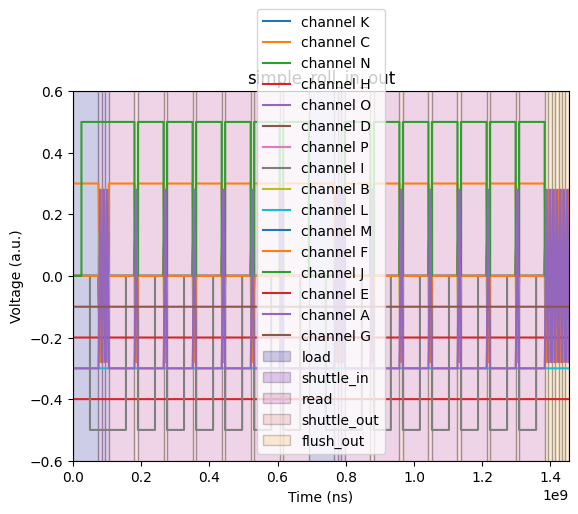

In [17]:
# plot pt
from qupulse.pulses.plotting import plot

_ = plot(roll_in_n_out_complete, default_params,
         # plot_channels=tuple('ABCEFGHN'),
         plot_measurements={'load', 'shuttle_in', 'shuttle_out', 'read', 'flush_out'},
         sample_rate = default_params['sample_rate'])

## Task 2: Tune both sides:

Due to gate parity, additional half period is required for a shuttle through.


In [39]:
import sympy

frac_period = sympy.symbols('frac_period')

shuttle_frac_period = shuttle_period * frac_period

print(shuttle_frac_period)


frac_period*n_segments*ceiling(sample_rate/(f*n_segments))/sample_rate


In [40]:
from qupulse.pulses.plotting import plot

# try to add half period

arbitrary_shuttle_frac = MappingPT(arbitrary_shuttle, parameter_mapping={'duration': shuttle_frac_period})
print(arbitrary_shuttle_frac.parameter_mapping)
print(default_params['frac_period'])

frozendict.frozendict({'duration': ExpressionScalar('frac_period*n_segments*ceiling(sample_rate/(f*n_segments))/sample_rate'), 'sample_rate': ExpressionScalar('sample_rate'), 'phi': ExpressionScalar('phi'), 'f': ExpressionScalar('f'), 'amp_B': ExpressionScalar('amp_B'), 'amp_F': ExpressionScalar('amp_F'), 'amp_K': ExpressionScalar('amp_K'), 'amp_C': ExpressionScalar('amp_C'), 'amp_A': ExpressionScalar('amp_A'), 'n_segments': ExpressionScalar('n_segments'), 'amp_D': ExpressionScalar('amp_D')})
0.5


{'B', 'K', 'C', 'F', 'A', 'D'}


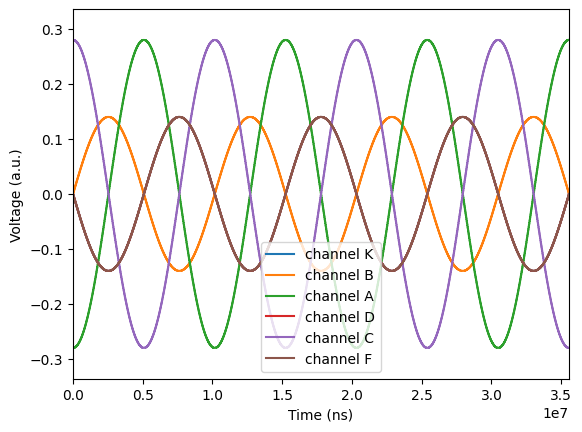

In [41]:

shuttle_in_varPeriod = MappingPT(RepetitionPT(arbitrary_shuttle, 'n_period_in') @ arbitrary_shuttle_frac,
                                parameter_mapping={'duration': shuttle_period, 'phi': 'global_phase'},
                                measurement_mapping={'shuttle': 'shuttle_in'})

_=plot(shuttle_in_varPeriod, parameters=default_params, sample_rate = default_params['sample_rate'])
print(shuttle_in.defined_channels)

Append fractional period is possible, but apparently voltages of clavier gates don't match reading levels.

### Idea:
Try to get the final states of clavier gates from `shuttle_in_varPeriod`

{'A': ExpressionScalar('amp_A*sin(2*pi*frac_period + global_phase)'), 'B': ExpressionScalar('amp_B*cos(2*pi*frac_period + global_phase)'), 'C': ExpressionScalar('-amp_C*sin(2*pi*frac_period + global_phase)'), 'D': ExpressionScalar('-amp_D*cos(2*pi*frac_period + global_phase)'), 'F': ExpressionScalar('-amp_F*cos(2*pi*frac_period + global_phase)'), 'K': ExpressionScalar('-amp_K*cos(2*pi*frac_period + global_phase)')}


c:\users\xuera\documents\python\qupulse\qupulse\pulses\plotting.py:181: UserWarning: Sample count 289959/32 is not an integer. Will be rounded (this changes the sample rate).
  time_slice=time_slice)


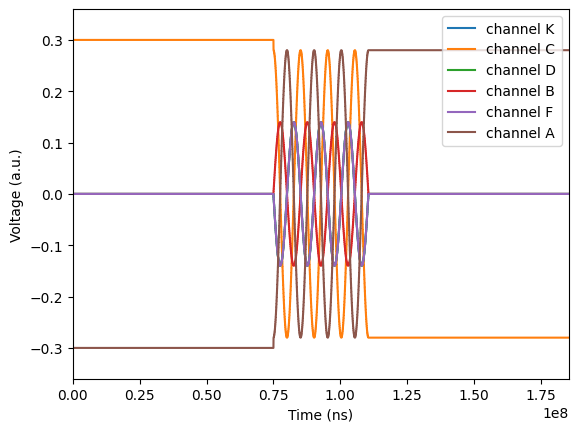

In [56]:
print(shuttle_in_varPeriod.final_values)    # surprisingly qupulse stores final_values as expressions

# Plug load, shuttle in and read together => PL1 --> S+n --> DL1
channels_onhold = load_full.defined_channels - shuttle_in_varPeriod.defined_channels

# overwrite channels by the final value
read_pls_mod = ParallelChannelPT(read_pls,
                                overwritten_channels={ch: val for ch, val in shuttle_in_varPeriod.final_values.items()})

period_in = load_full @ ParallelChannelPT(shuttle_in_varPeriod, overwritten_channels={ch: f"V_load_3[{ord(ch)-ord('A')}]" for ch in channels_onhold}) @ read_pls_mod
_ = plot(period_in, default_params,
        plot_channels=shuttle_in_varPeriod.defined_channels,
        sample_rate=default_params['sample_rate'])


Now the final pulse is as follows:

In [1]:
from qupulse.pulses import *
from qupulse.pulses import ParallelConstantChannelPT as ParallelChannelPT
# since when ParallelChannelPT is not a short-cut to ParallelConstantChannelPT?
import sympy

# Make load and read blocks
read_pls = PointPT([
    ('t_read_0', 'V_read_0'),
    ('t_read_1', 'V_read_1'),
    ('t_read_2', 'V_read_2'),
    ('t_read_3', 'V_read_3'),
    ], tuple('ABCDEFGHIJKLMNOP'), measurements=[('read', 0, 't_read_3')])


load_full = PointPT([
    ('t_load_0', 'V_load_0'),
    ('t_load_1', 'V_load_1'),
    ('t_load_2', 'V_load_2'),
    ('t_load_3', 'V_load_3'),
    ], tuple('ABCDEFGHIJKLMNOP'), measurements=[('load', 0, 't_load_3')])

load_empty = MappingPT(load_full, parameter_mapping={'V_load_0': 'V_empty_0',
                                                     'V_load_1': 'V_empty_1',
                                                     'V_load_2': 'V_empty_2',
                                                     'V_load_3': 'V_empty_3'})

# define sinewaves by FunctionPT

# sympify some useful parameters:
# ------ AWG parameters ---------
#   sample_rate: sample_rate of AWG = Clock rate / 2**division power in GHz. 100MHz / 2^11 = 48.8 kHz might be sufficient.
#   n_segments:  default is 16 which is also the minimum of HDAWG. Empirically suggested by Simon: 192.
# ------ shuttle parameters -----
#   f:           shuttle frequency (! Might be some division issue from matlab thus sophisticated calculated later on)

sample_rate, f, n_segments, frac_period = sympy.symbols('sample_rate, f, n_segments, frac_period')
segment_time = n_segments / sample_rate

shuttle_period = sympy.ceiling(1 / f / segment_time) * segment_time
shuttle_frac_period = shuttle_period * frac_period
actual_frequency = 1 / shuttle_period

# Make a shuttle pulse including 4 clavier gates + 2 individual gates on each side.
arbitrary_shuttle = AtomicMultiChannelPT(
    FunctionPT(f'amp_A * sin(2*pi*{actual_frequency}*t + 0 +          phi)', duration_expression='duration', channel='A'),
    FunctionPT(f'amp_B * sin(2*pi*{actual_frequency}*t + pi / 2 +     phi)', duration_expression='duration', channel='B'),
    FunctionPT(f'amp_C * sin(2*pi*{actual_frequency}*t + pi     +     phi)', duration_expression='duration', channel='C'),
    FunctionPT(f'amp_D * sin(2*pi*{actual_frequency}*t + pi * 3 / 2 + phi)', duration_expression='duration', channel='D'),

    # >> Add T gates for both ends with consistent channel names ('F': TRB2 <- S4, 'K': TLB2 <- S4)
    FunctionPT(f'amp_F * sin(2*pi*{actual_frequency}*t + pi * 3 / 2 + phi)', duration_expression='duration', channel='F'),
    FunctionPT(f'amp_K * sin(2*pi*{actual_frequency}*t + pi * 3 / 2 + phi)', duration_expression='duration', channel='K'),
    measurements=[('shuttle', 0, 'duration')]
    )

arbitrary_shuttle_frac = MappingPT(arbitrary_shuttle, parameter_mapping={'duration': shuttle_frac_period})

shuttle_in_varPeriod = MappingPT(RepetitionPT(arbitrary_shuttle, 'n_period_in') @ arbitrary_shuttle_frac,
                                parameter_mapping={'duration': shuttle_period, 'phi': 'global_phase'},
                                measurement_mapping={'shuttle': 'shuttle_in'})

shuttle_out_frac = MappingPT(TimeReversalPT(arbitrary_shuttle_frac),
                            parameter_mapping={'phi': 'global_phase'},
                            measurement_mapping={'shuttle': 'shuttle_out'})

shuttle_out = MappingPT(RepetitionPT(TimeReversalPT(arbitrary_shuttle), 'n_period_read'),
                        parameter_mapping={'duration': shuttle_period, 'phi': 'global_phase'},
                        measurement_mapping={'shuttle': 'shuttle_out'})

flush_out = MappingPT(RepetitionPT(TimeReversalPT(arbitrary_shuttle), 'n_period_flush'),
                      parameter_mapping={'duration': shuttle_period, 'phi': 'global_phase'},
                      measurement_mapping={'shuttle': 'flush_out'})


# Plug load, shuttle in and read together => PL1 --> S+n --> DL1
channels_onhold = load_full.defined_channels - shuttle_in_varPeriod.defined_channels

# overwrite channels by the final value
read_pls_mod = ParallelChannelPT(read_pls,
                                overwritten_channels={ch: val for ch, val in shuttle_in_varPeriod.final_values.items()})
period_in = load_full @ ParallelChannelPT(shuttle_in_varPeriod, overwritten_channels={ch: f"V_load_3[{ord(ch)-ord('A')}]" for ch in channels_onhold}) @ read_pls_mod

# plug read and shuttle out => S(-.x) --> D --> S(-n' per read) --> DL1
channels_onhold = read_pls.defined_channels - shuttle_out.defined_channels
period_out = ParallelChannelPT(shuttle_out, overwritten_channels={ch: f"V_read_3[{ord(ch)-ord('A')}]" for ch in channels_onhold}) @ read_pls
period_frac_out = RepetitionPT(ParallelChannelPT(shuttle_out_frac,
                        overwritten_channels={ch: f"V_read_3[{ord(ch)-ord('A')}]" for ch in channels_onhold}) @ read_pls,
                        repetition_count=sympy.ceiling(frac_period)
)

# repeated read and shuttle out => S(-.x) --> D --> [S(-n' per read) --> DL1] x (n_in + n_extra)
tot_period_out = period_frac_out @ RepetitionPT(period_out, 'n_period_in + n_period_extra')

# make a flush pulse according to the last read.
channels_onhold = read_pls.defined_channels - flush_out.defined_channels
flush = ParallelChannelPT(flush_out, overwritten_channels={ch: f"V_read_3[{ord(ch)-ord('A')}]" for ch in channels_onhold})

# roll-in roll-out of 1 electron

roll_in_n_out = period_in @ tot_period_out

# empty roll-in roll-out:
roll_in_n_out_empty = MappingPT(roll_in_n_out, parameter_mapping={'V_load_0': 'V_empty_0',
                                                                  'V_load_1': 'V_empty_1',
                                                                  'V_load_2': 'V_empty_2',
                                                                  'V_load_3': 'V_empty_3'})

# the whole sequence will be roll in&out with 1e + without 1e + flush pulse
roll_in_n_out_complete = MappingPT(roll_in_n_out @ roll_in_n_out_empty @ flush,
                                   identifier='simple_roll_in_out')


c:\users\xuera\documents\python\qupulse\qupulse\pulses\plotting.py:181: UserWarning: Sample count 2537951/32 is not an integer. Will be rounded (this changes the sample rate).
  time_slice=time_slice)
c:\Users\xuera\Documents\PYTHON\qupulse\my_expDev\lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\xuera\Documents\PYTHON\qupulse\my_expDev\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


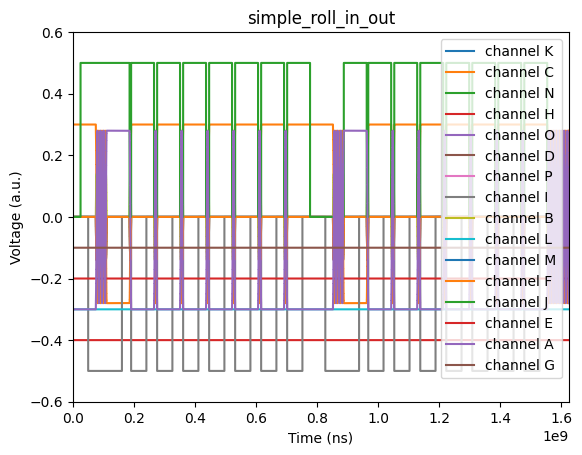

In [66]:
# Now if we shuttle additional half peirod

default_params['frac_period'] = 0.5
_ = plot(roll_in_n_out_complete, default_params, sample_rate=default_params['sample_rate'])

c:\users\xuera\documents\python\qupulse\qupulse\pulses\plotting.py:181: UserWarning: Sample count 808081087999999999/10240000000000 is not an integer. Will be rounded (this changes the sample rate).
  time_slice=time_slice)
c:\Users\xuera\Documents\PYTHON\qupulse\my_expDev\lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\xuera\Documents\PYTHON\qupulse\my_expDev\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


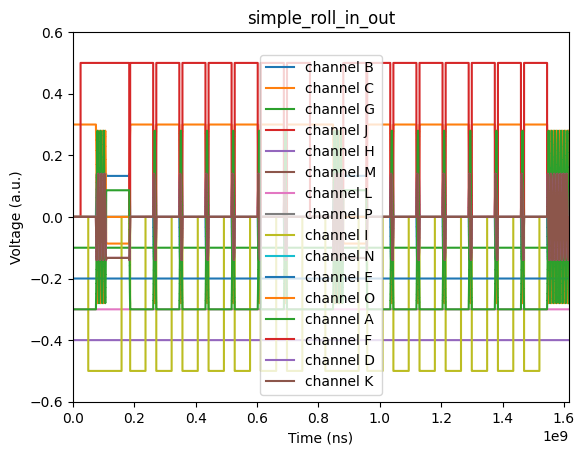

In [8]:
from qupulse.pulses.plotting import plot
# Now if we shuttle full peirods

default_params['frac_period'] = 0.3
_ = plot(roll_in_n_out_complete, default_params, sample_rate=default_params['sample_rate'])

### Foreseeable problem:

If no fractional shuttle is required i.e. `default_params['frac_period'] = 0`, the reading pulse after shuttle in will be duplicated. May be wrap the `period_frac_out` into a `RepetitionPT` with iteration count `ceil(default_params['frac_period'])`. But it is unclear wheather repeating 0 times will be interpreted as skipping current pulse template. Further test is needed.

c:\users\xuera\documents\python\qupulse\qupulse\pulses\repetition_pulse_template.py:67: UserWarning: Repetition pulse template with 0 repetitions on construction.
  warn("Repetition pulse template with 0 repetitions on construction.")
c:\users\xuera\documents\python\qupulse\qupulse\pulses\plotting.py:181: UserWarning: Sample count 234439/64 is not an integer. Will be rounded (this changes the sample rate).
  time_slice=time_slice)


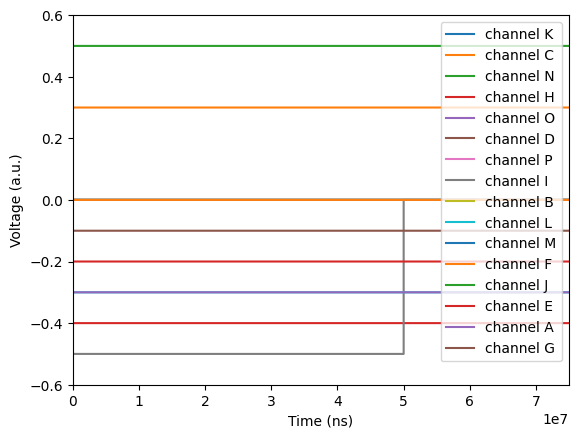

In [63]:
test_0_rep = RepetitionPT(period_frac_out, 0)

test_0_rep_n_read = test_0_rep @ read_pls

_ = plot(test_0_rep_n_read, default_params, sample_rate=default_params['sample_rate'])

Alright, mission complete

## Task 3: Use volatile parameters

Make the following parameters volatile such that qupulse will dynamically modify them for 'autotunning'.
* frac_period: enables a sub-period resolution to locate the charge defect in the channel.
* V_read_x: it is possible to fine tune reading voltages.

According to the dnp example, volatile parameters are set at the program level therefore we need define hardware and connect to AWG to test runtime.

In [ ]:
from qupulse.hardware.setup import HardwareSetup
from doc.source.examples.hardware.zhinst import add_to_hardware_setup

awg_name = 'myHDAWG'
awg_address = None
hardware_setup = HardwareSetup()

hdawg, channel_pairs = add_to_hardware_setup(hardware_setup, awg_address, name=awg_name)
used_awg = hdawg.channel_pair_AB


In [5]:
# pulse for testing
test = roll_in_n_out_complete
test_prog = test.create_program(parameters=default_params,
                                volatile='frac_period') # <-- I got a None after creating program...
                                # --- ehh, AtomicPT cannot be volatile.
test_prog.cleanup() # why cleanup?

hardware_setup.register_program('test', test_prog)
hardware_setup.arm_program('test')

used_awg.run_current_program()

print(used_awg._known_programs['test'].program.program)

AssertionError: AtomicPT cannot be volatile

## Task 4: Load an arbitrary binary pattern

Loading an customized binary pattern in to QuBus by a generallized loading pulse.

In [4]:
from qupulse.pulses import *
from qupulse.pulses import ParallelConstantChannelPT as ParallelChannelPT
# since when ParallelChannelPT is not a short-cut to ParallelConstantChannelPT?
import sympy

# Make load and read blocks
read_pls = PointPT([
    ('t_read_0', 'V_read_0'),
    ('t_read_1', 'V_read_1'),
    ('t_read_2', 'V_read_2'),
    ('t_read_3', 'V_read_3'),
    ], tuple('ABCDEFGHIJKLMNOP'), measurements=[('read', 0, 't_read_3')])


arbitrary_load = PointPT([
    ('t_load_0', 'V_load_0 * bit_flag + V_empty_0 * (1 - bit_flag)'),
    ('t_load_1', 'V_load_1 * bit_flag + V_empty_1 * (1 - bit_flag)'),
    ('t_load_2', 'V_load_2 * bit_flag + V_empty_2 * (1 - bit_flag)'),
    ('t_load_3', 'V_load_3 * bit_flag + V_empty_3 * (1 - bit_flag)'),
    ], tuple('ABCDEFGHIJKLMNOP'), measurements=[('load', 0, 't_load_3')])

load_bit = MappingPT(arbitrary_load, parameter_mapping={'bit_flag': 'pattern[bit]'})

In [5]:
print(load_bit.parameter_mapping)

frozendict.frozendict({'bit_flag': ExpressionScalar('pattern[bit]'), 'V_empty_0': ExpressionScalar('V_empty_0'), 't_load_1': ExpressionScalar('t_load_1'), 'V_empty_2': ExpressionScalar('V_empty_2'), 't_load_0': ExpressionScalar('t_load_0'), 't_load_2': ExpressionScalar('t_load_2'), 'V_load_2': ExpressionScalar('V_load_2'), 'V_load_1': ExpressionScalar('V_load_1'), 'V_load_0': ExpressionScalar('V_load_0'), 'V_empty_3': ExpressionScalar('V_empty_3'), 'V_empty_1': ExpressionScalar('V_empty_1'), 't_load_3': ExpressionScalar('t_load_3'), 'V_load_3': ExpressionScalar('V_load_3')})


In [6]:
test = ForLoopPT(load_bit, 'bit', 'len(pattern)')


In [8]:
default_params = {}
for n in ('load', 'read', 'empty'):
    for ii in range(4):
        default_params[f't_{n}_{ii}'] = ii*25e6

default_params = {**default_params,
    #              A,   B,   C,   D,   E,    F,    G,    H,    I,   J,    K,   L,   M,   N,   O,   P
    #             S1,  S2,  S3,  S4, TRP, TRB2,  RB2, TRB1, TLB1, TLP, TLB2, LB2, LB1, RB1, EMP, CLK
    'V_load_0': [-.3,  0.,  .3,  0., -.2,   0.,  -.1,  -.4,   0.,  0.,    0, -.3,  0.,  0.,  0.,  0.],
    'V_load_1': [-.3,  0.,  .3,  0., -.2,   0.,  -.1,  -.4,   0.,  .5,    0, -.3,  0.,  0.,  0.,  0.],
    'V_load_2': [-.3,  0.,  .3,  0., -.2,   0.,  -.1,  -.4,  -.5,  .5,    0, -.3,  0.,  0.,  0.,  0.],
    'V_load_3': [-.3,  0.,  .3,  0., -.2,   0.,  -.1,  -.4,  -.5,  .5,    0, -.3,  0.,  0.,  0.,  0.],

    'V_empty_0': [-.3,  0.,  .3,  0., -.2,   0.,  -.1,  -.4,   0.,  0.,    0, -.3,  0.,  0.,  0.,  0.],
    'V_empty_1': [-.3,  0.,  .3,  0., -.2,   0.,  -.1,  -.4,   0.,  0.,    0, -.3,  0.,  0.,  0.,  0.],
    'V_empty_2': [-.3,  0.,  .3,  0., -.2,   0.,  -.1,  -.4,  -.5,  0.,    0, -.3,  0.,  0.,  0.,  0.],
    'V_empty_3': [-.3,  0.,  .3,  0., -.2,   0.,  -.1,  -.4,  -.5,  0.,    0, -.3,  0.,  0.,  0.,  0.],

    'pattern': [0, 0, 1, 0, 0, 1]
}

print(default_params)

{'t_load_0': 0.0, 't_load_1': 25000000.0, 't_load_2': 50000000.0, 't_load_3': 75000000.0, 't_read_0': 0.0, 't_read_1': 25000000.0, 't_read_2': 50000000.0, 't_read_3': 75000000.0, 't_empty_0': 0.0, 't_empty_1': 25000000.0, 't_empty_2': 50000000.0, 't_empty_3': 75000000.0, 'V_load_0': [-0.3, 0.0, 0.3, 0.0, -0.2, 0.0, -0.1, -0.4, 0.0, 0.0, 0, -0.3, 0.0, 0.0, 0.0, 0.0], 'V_load_1': [-0.3, 0.0, 0.3, 0.0, -0.2, 0.0, -0.1, -0.4, 0.0, 0.5, 0, -0.3, 0.0, 0.0, 0.0, 0.0], 'V_load_2': [-0.3, 0.0, 0.3, 0.0, -0.2, 0.0, -0.1, -0.4, -0.5, 0.5, 0, -0.3, 0.0, 0.0, 0.0, 0.0], 'V_load_3': [-0.3, 0.0, 0.3, 0.0, -0.2, 0.0, -0.1, -0.4, -0.5, 0.5, 0, -0.3, 0.0, 0.0, 0.0, 0.0], 'V_empty_0': [-0.3, 0.0, 0.3, 0.0, -0.2, 0.0, -0.1, -0.4, 0.0, 0.0, 0, -0.3, 0.0, 0.0, 0.0, 0.0], 'V_empty_1': [-0.3, 0.0, 0.3, 0.0, -0.2, 0.0, -0.1, -0.4, 0.0, 0.0, 0, -0.3, 0.0, 0.0, 0.0, 0.0], 'V_empty_2': [-0.3, 0.0, 0.3, 0.0, -0.2, 0.0, -0.1, -0.4, -0.5, 0.0, 0, -0.3, 0.0, 0.0, 0.0, 0.0], 'V_empty_3': [-0.3, 0.0, 0.3, 0.0, -0.2, 0.

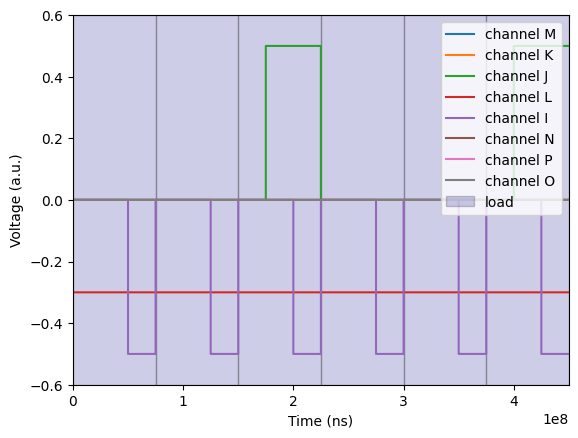

In [13]:
from qupulse.pulses.plotting import plot

_ = plot(test, parameters = default_params, 
         plot_measurements=['load'],
         plot_channels=('IJKLMNOP'),
         sample_rate = 1e-5)